In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import Union

from langchain.schema import Document
from langchain_core.vectorstores import VectorStoreRetriever
from langchain.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain_neo4j import Neo4jVector
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

from ragas.dataset_schema import EvaluationResult
from ragas import EvaluationDataset
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import (
    SemanticSimilarity,
    AnswerRelevancy, 
    Faithfulness, 
    FactualCorrectness, 
    AnswerCorrectness, 
    LLMContextRecall, 
    ContextRecall, 
    ContextPrecision, 
)

metrics_list = [
    Faithfulness(),
    AnswerRelevancy(),
    SemanticSimilarity(),
    
]

np.random.seed(42)

In [2]:
# Eval setting
SUBSET_SIZE = -1
EVAL_CACHE_DIR = "eval/"
USE_CACHE = True
EVAL_SET = [
    "VectorRAG_Baseline", 
    "Microsoft_GraphRAG"
]

# General RAG setting
TOP_K = 3

# Vector RAG setting
CHUNK_SIZE = 512
CHUNK_OVERLAP = 32

In [3]:
# load environment variables
from dotenv import load_dotenv
load_dotenv("./private-config.env")

True

In [4]:
def empty_cache():
    os.remove(EVAL_CACHE_DIR, ignore_errors=True)
    os.remove(os.environ["CHROMA_DB"], ignore_errors=True)
    os.remove(os.environ["QR_DATA"], ignore_errors=True)

if not USE_CACHE:
    empty_cache()

### LLM Config

In [5]:
# Embedding model
embed = OpenAIEmbeddings()

# LLM model
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

### QR Dataset Preparation

In [6]:
# def prepare_product_df() -> pd.DataFrame:
#     """
#     Load the Amazon product dataset and filter for beauty products.
#     """
#     import datasets
#     amazon_product = datasets.load_dataset("milistu/AMAZON-Products-2023")
#     df = amazon_product["train"].to_pandas()
#     beauty_products = df[df['main_category'] == 'All Beauty']
#     return beauty_products


def prepare_product_df():
    # Read data from a text file
    with open('data/message.txt', 'r', encoding='utf-8') as file:
        data = file.read()

    # Split into products by splitting on double newlines
    products = data.strip().split('\n\n')

    # Prepare list to hold each product's data
    product_list = []

    for product in products:
        product_data = {}

        # Extract each line that contains ':'
        lines = product.split('\n')
        for line in lines:
            if ':' in line:
                key, value = line.split(':', 1)  # Split only at the first colon
                product_data[key.strip().lower()] = value.strip()

        product_list.append(product_data)

    # Convert list to DataFrame
    return pd.DataFrame(product_list)

In [7]:
async def generate_qr_data(
        df: pd.DataFrame, 
        llm: ChatOpenAI,
        metadata_fields: list = ["description", "title"],
        num_questions_per_chunk: int = 1,
    ) -> pd.DataFrame:
    """
    Generate QR data for the given DataFrame.
    """
    from llama_index.core import Document
    from llama_index.core.evaluation import DatasetGenerator
    cols = df.columns

    docs = []
    for i, row in df.iterrows():
        doctext = [f"{col}: {row[col]}" for col in cols]
        doctext = "\n".join(doctext)
        doc = Document(
            text=doctext,
            metadata={field: row[field] for field in metadata_fields},
        )
        docs.append(doc)

    dataset_generator = DatasetGenerator.from_documents(
        docs,
        num_questions_per_chunk=num_questions_per_chunk,
        show_progress=True,
    )
    qr_ds = await dataset_generator.agenerate_dataset_from_nodes()
    qr_ds.save_json(os.environ["QR_DATA"])
    qr_ds = {
        "queries": qr_ds.queries,
        "responses": qr_ds.responses,
    }
    return qr_ds


# Load QA data
df = prepare_product_df()
if not os.path.exists(os.environ["QR_DATA"]):
    df = prepare_product_df()
    print(f"Loaded {len(df)} products")
    qr_data = await generate_qr_data(
        df,
        llm,
        metadata_fields=["description", "title"],
        num_questions_per_chunk=1,
    )
else:
    with open(os.environ["QR_DATA"], "r") as f:
        qr_data = json.load(f)
    

In [8]:
# load question-response dataset in json format for evaluation
questions = [q for q in qr_data['queries'].values()]
responses = [r for r in qr_data['responses'].values()]
size = len(questions)
idx = np.random.randint(0, size, SUBSET_SIZE) if SUBSET_SIZE > 0 else np.arange(size)
questions, responses = [questions[i] for i in idx], [responses[i] for i in idx]
len(questions), len(responses)

(27, 27)

### Vector RAG

In [9]:
def df2docs(df: pd.DataFrame) -> list[Document]:
    """
    Convert DataFrame to list of Documents.
    """
    docs = []
    for i, row in df.iterrows():
        doctext = [f"{col}: {row[col]}" for col in df.columns]
        doctext = "\n".join(doctext)
        doc = Document(
            page_content=doctext,
            metadata={col: row[col] for col in df.columns},
        )
        docs.append(doc)
    return docs


documents = df2docs(df)
# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)
docstore = text_splitter.split_documents(documents)

# Create ChromaDB and store embeddings
db = Chroma.from_documents(docstore, embed, persist_directory="./chroma_db")

# Create a retriever
vecstore = db.as_retriever(search_kwargs={"k": TOP_K})

### GraphRAG

In [10]:
url = os.getenv("NEO4J_CONNECTION_URL")
username = os.getenv("NEO4J_USER")
password = os.getenv("NEO4J_PASSWORD")

In [11]:
graph_vecstore = Neo4jVector.from_existing_graph(
    embedding=embed,
    url=url,
    username=username,
    password=password,
    index_name="product_index",
    node_label="Product",
    text_node_properties=["description"],
    embedding_node_property="embedding",
)

In [12]:
# graph_vecstore = Neo4jVector.from_existing_index(
#     OpenAIEmbeddings(),
#     url=url,
#     username=username,
#     password=password,
#     index_name="product_index",
# )

### Evaluation on Question Answering Task

In [13]:
RETRIEBERT_CONFIG = {
    "Vector RAG (Baseline)": vecstore,
    "Microsoft GraphRAG": graph_vecstore,
}

In [14]:
def eval_qr_data(
        questions: list[str], 
        responses: list[str], 
        retriever: Union[VectorStoreRetriever, Neo4jVector], 
        llm: ChatOpenAI,
    ) -> EvaluationDataset:
    """
    Wraps the evaluation data into a list of dictionaries.
    """
    dataset = []

    for query, reference in tqdm(zip(questions, responses), total=len(questions)):

        if isinstance(retriever, VectorStoreRetriever):
            relevant_docs = retriever.invoke(query)
        elif isinstance(retriever, Neo4jVector):
            relevant_docs = retriever.similarity_search(query, k=TOP_K)
        else:
            raise ValueError("Unsupported retriever type")
        
        relevant_context = "\n".join([doc.page_content for doc in relevant_docs])
        prompt = f"""
        Based on the following context, answer the question:\n
        {relevant_context}\n
        Question: {query}\n
        Answer:
        """
        response = llm.invoke(prompt).content
        dataset.append(
            {
                "user_input":query,
                "retrieved_contexts":[d.page_content for d in relevant_docs],
                "response":response,
                "reference":reference
            }
        )

    return EvaluationDataset.from_list(dataset)

def eval(method: str, eval_llm: ChatOpenAI) -> EvaluationResult:
    retriever = RETRIEBERT_CONFIG[method]
    print(f"Evaluating {method} ...")
    # Prepare the evaluation data
    eval_data = eval_qr_data(
        questions=questions,
        responses=responses,
        retriever=retriever,
        llm=llm,
    )
    # Eval
    eval_result = evaluate(
        dataset=eval_data,
        metrics=metrics_list,
        llm=eval_llm,
    )
    # Save the evaluation result
    eval_result.to_pandas().to_csv(
        os.path.join(EVAL_CACHE_DIR, f"{method}.csv"),
    )
    return eval_result

In [15]:
def parse_eval_results(
        eval_result: Union[EvaluationResult, pd.DataFrame], 
        method_name: str,
    ) -> pd.DataFrame:
    """
    Parses the evaluation results into a DataFrame.
    """
    if isinstance(eval_result, EvaluationResult):
        # Convert the evaluation result to a DataFrame
        eval_df = eval_result.to_pandas()
        metrics_names = [i for i in eval_result.scores[0].keys()]
    else:
        # If it's already a DataFrame, use it directly
        eval_df = eval_result
        metrics_names = [col for col in eval_result.columns if col not in ["user_input", "retrieved_contexts", "response", "reference"]]
    eval_df_long = pd.melt(
        eval_df,
        value_vars=metrics_names,  # Columns to unpivot
        var_name='metric',             # Name for the variable column
        value_name='score'              # Name for the value column
    )
    eval_df_long['method'] = method_name
    return eval_df_long

In [16]:
evaluator_llm = LangchainLLMWrapper(llm)

In [17]:
eval_df = pd.DataFrame()
if not os.path.exists(EVAL_CACHE_DIR):
    os.makedirs(EVAL_CACHE_DIR)
for method in EVAL_SET:
    if os.path.exists(os.path.join(EVAL_CACHE_DIR, f"{method}.csv")):
        print(f"Loading result of {method} ...")
        eval_result = pd.read_csv(os.path.join(EVAL_CACHE_DIR, f"{method}.csv"), index_col=0)
    else:
        eval_result = eval(method, evaluator_llm)
    df = parse_eval_results(eval_result, method)
    eval_df = pd.concat([eval_df, df], ignore_index=True)
eval_df.shape

Loading result of VectorRAG_Baseline ...
Loading result of Microsoft_GraphRAG ...


(162, 3)

In [18]:
eval_df.head()

,metric,score,method
0,faithfulness,0.500000,VectorRAG_Baseline
1,faithfulness,1.000000,VectorRAG_Baseline
2,faithfulness,1.000000,VectorRAG_Baseline
3,faithfulness,1.000000,VectorRAG_Baseline
4,faithfulness,0.833333,VectorRAG_Baseline


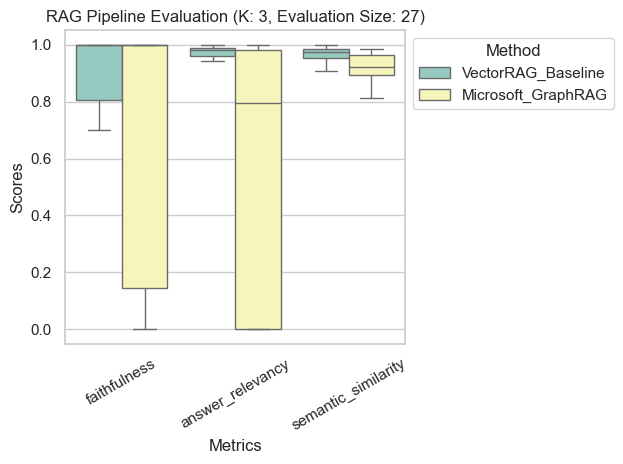

In [19]:
# boxplot for all metrics
sns.set(style="whitegrid")
sns.boxplot(
    x="metric",
    y="score",
    hue="method",
    hue_order=EVAL_SET,
    data=eval_df,
    palette="Set3",
    showfliers=False,
)
plt.xticks(rotation=30)
plt.title(f"RAG Pipeline Evaluation (K: {TOP_K}, Evaluation Size: {SUBSET_SIZE if SUBSET_SIZE > 0 else size})")
plt.legend(title="Method", loc="upper left", bbox_to_anchor=(1, 1))
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.tight_layout()
# Save the evaluation results to a CSV file